In [99]:
import re
import networkx as nx
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from fa2 import ForceAtlas2
import seaborn as sns

# A) Visualize the House of Representatives Network

In [100]:
import re
import networkx as nx
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
from aux import *
from fa2 import ForceAtlas2

# Converts degree dictionary to numpy array
def degree_array(G, direction="none"):
    if direction == "in":
        return np.array(list(dict(G.in_degree()).values()))
    elif direction == "out":
        return np.array(list(dict(G.out_degree()).values()))
    else:
        return np.array(list(dict(G.degree()).values()))

def flatten_edgelist(G):
    return list(sum(G.edges(), ()))

# Creates a Barabasil-Abert graph given a number of nodes (N)
def BA_graph(N):
    # Create initial two nodes, with one link between them
    G = nx.Graph()
    G.add_edges_from([(0,1)])
    
    # Create the remaining N-2 nodes. Link based on degree
    for node in range(2, N):
        edges = flatten_edgelist(G)
        pick = random.choice(edges)
        G.add_edges_from([(node, pick)])
    
    return G
    
# Returns the average degree of all neighbors, given a graph and a node.
def neighbors_avg_degree(G, node):
    nb = ba_graph_5k.neighbors(node)
    degrees = np.array(list(dict(G.degree(nb)).values()))
    return np.mean(degrees)

# Reads a WikiPage txt file, scans it for links to other Wikipages,
# and returns a list of the found links
def get_article_links(name, year, path_folder):
    # The regex pattern for recognizing links on the form [x | y]
    # and only capturing 'x'.
    article_pattern = r'\[\[([^\]]*?)(?:\|.*?)*\]\]'
    article = io.open(path_folder + name + year + ".txt", 'r', encoding='utf-8').read()
    article_links = re.findall(article_pattern, article)
    article_links = [a.replace(' ', '_') for a in article_links]
    return article_links

# A politcian class for storing data in a neat way.
class Politician:
    def __init__(self, dfRow):
        self.WikiPageName = str(dfRow[0])
        self.Party = str(dfRow[1])
        self.State = str(dfRow[2])
    
    def to_string(self):
        return "Wiki: %s, Party: %s, State: %s" % (self.WikiPageName, self.Party, self.State)
    
    def __hash__(self):
        return hash(self.WikiPageName)
    def __eq__(self, other):
        return (
                self.__class__ == other.__class__ and 
                self.WikiPageName == other.WikiPageName
               )

# Plots the degree distribution, and the log-log degree distribution,
# as a scatter plots
def scatter_degree_distribution(degrees, text=""):
    v = range(min(degrees), max(degrees)+1)
    hist = np.histogram(degrees, bins=v)
    freqs, edges = hist[0], hist[1]
    n = freqs.size
    means = [(edges[i] + edges[i+1]) / 2 for i in range(n)]
    
    plt.plot(means, freqs, ".")
    plt.xlabel("k")
    plt.ylabel("frequency")
    plt.title("Degree distribution %s" % text)
    plt.show()
    
    plt.loglog(means, freqs, ".")
    plt.xlabel("k")
    plt.ylabel("frequency")
    plt.title("Log-Log plot of the Degree distribution %s" % text)
    plt.show()
    
# Plots a histogram, given the degrees of a graph.
def distribution_histogram(degrees, text=""):
    v = np.arange(min(degrees), max(degrees)+1)
    plt.figure(figsize=(10,5))
    plt.hist(degrees, bins=v, edgecolor="black")
    plt.title("Degree distribution %s" % text)
    plt.xlabel("Degree (k)")
    plt.ylabel("Frequency (nodes)")
    plt.show()

def fa_positions(graph):
    forceatlas2 = ForceAtlas2(
        # Behavior alternatives
        outboundAttractionDistribution=False,  # Dissuade hubs
        linLogMode=False,  # NOT IMPLEMENTED
        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
        edgeWeightInfluence=1.0,

        # Performance
        jitterTolerance=1.0,  # Tolerance
        barnesHutOptimize=True,
        barnesHutTheta=1.2,
        multiThreaded=False,  # NOT IMPLEMENTED

        # Tuning
        scalingRatio=2.0,
        strongGravityMode=False,
        gravity=1.0,

        # Log
        verbose=False
    )

    return forceatlas2.forceatlas2_networkx_layout(graph, pos=None, iterations=2000)

In [101]:
df = pd.read_csv('../week4/dataset/H113.csv')
wiki_page_names = list(df.WikiPageName)

## Exercise 1: Pick one of the houses of representatives (113th, 114th, 115th), and build the network.
* Use NetworkX DiGraph to store the network. Store also the properties of the nodes (state and party of each politician).

In [102]:
congressGraph = nx.DiGraph()

for index, row in df.iterrows():
    # Create politician node
    p = Politician(row)
    congressGraph.add_node(p)
    
    # Get links
    wikiPageName = row[0]
    articleLinks = get_article_links(wikiPageName, "2015", "../week4/WikiPages2015/")
    for link in articleLinks:
        if link in wiki_page_names:
            linkIndex = wiki_page_names.index(link)
            linkRow = df.iloc[linkIndex]
            q = Politician(linkRow)
            congressGraph.add_edge(p, q)

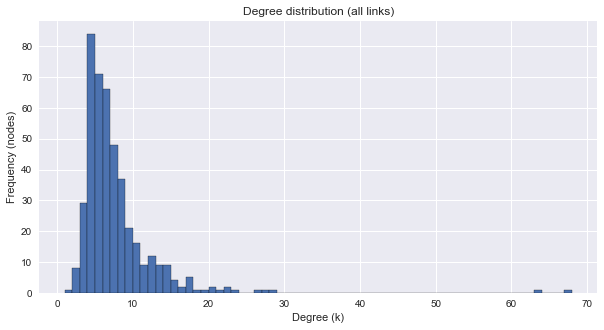

In [103]:
degrees = degree_array(congressGraph)
distribution_histogram(degrees, "(all links)")

* Try to visualize the network, using Networkx draw_spring. Do you think it looks nice?
     * No.

## Exercise 2: Visualize the network of the house of representatives.

In [104]:
undirectedCongressGraph = congressGraph.to_undirected()

In [105]:
politicians = undirectedCongressGraph.nodes()
degrees = 2 * np.array(degree_array(undirectedCongressGraph))
color_map = []
for p in politicians:
    if p.Party == "Republican": 
        color_map.append("red")
    elif p.Party == "Democratic": 
        color_map.append("blue")
    else: 
        color_map.append("#black")

In [106]:
positions = fa_positions(undirectedCongressGraph)

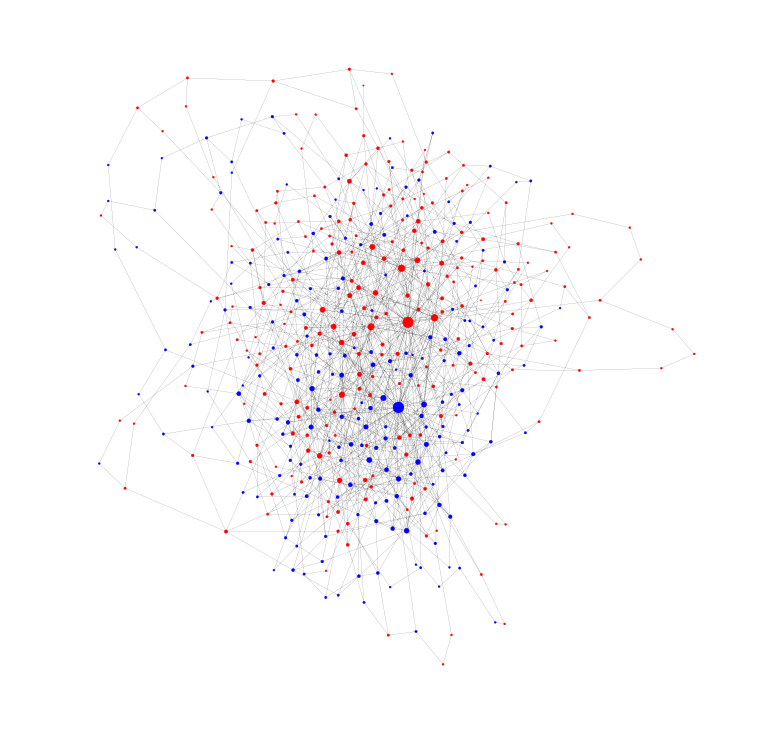

In [107]:
plt.figure(figsize=(10,10))
nx.draw(undirectedCongressGraph, positions, node_color=color_map, node_size=degrees, width=0.1)
plt.show()

* Describe the structure you observe. Can you identify nodes with a privileged position in the network? Do you observe chains of connected nodes?

*Answer: There is definately preferential attachment present in the graph; the two large nodes in the middle have many edges connected to them, and the degree of conenctedness decreases towards the outskirts of the graph*

* Compare the network you have produced with the one below, which shows the link structures between political blogs (see the full article here). How is our Wikipedia network different from the blogs?

In [108]:
from IPython.display import Image
Image(url='https://raw.githubusercontent.com/suneman/socialgraphs2018/master/files/blogosphere.jpg')

*Answer: The partitioned network shows that politicians generally link to other congress members from their own party, and not very often to members of the opposing party - these links are presumeably displayed in yellow.*

## Exercise 3: Think about the reasons for links between politicians to exist on Wikipedia.
* Find the node with highest out-degree in the network. Open the corresponding Wikipedia page.

In [109]:
outDegreeDict = congressGraph.out_degree()
sortedByOutDegree = sorted(outDegreeDict.keys(), key=lambda k: outDegreeDict[k], reverse=True)
sortedByOutDegree[0].WikiPageName

'Michele_Bachmann'

* Consider the set of neighbours of the node you identified above. Look for them in the page.

In [110]:
[p.WikiPageName for p in congressGraph.neighbors(sortedByOutDegree[0])]

['Tim_Walz',
 'Betty_McCollum',
 'Collin_Peterson',
 'Patrick_McHenry',
 'Lynn_Westmoreland',
 'John_Mica',
 'Ted_Poe',
 'Eric_Cantor',
 'Jeb_Hensarling',
 'John_Boehner',
 'Steve_King',
 'John_Kline_(politician)',
 'Louie_Gohmert',
 'Erik_Paulsen',
 'Darrell_Issa',
 'Spencer_Bachus',
 'Jan_Schakowsky',
 'Keith_Ellison',
 'Steve_Pearce_(politician)',
 'Gus_Bilirakis']

* What is the relation between the politician you identified and his/her network neighbours? (e.g. do they work together>, do they come from the same town?, are they are opponents? Etc.)

The first neighbours 

['Tim_Walz', 'Betty_McCollum', 'Collin_Peterson'] 

are political opponents of Michele: 

['Patrick_McHenry','Lynn_Westmoreland','John Mica' ] are allies

*Along with Congressman Ted Poe (Tex.-02), Bachmann introduced the American Community Survey Act to limit the amount of personal information solicited by the U.S. Census Bureau.*

* Repeat the exercise for the second largest out-degree node. Write down possible reasons why links exist between Wikipedia pages of politicians. Do all the links carry the same meaning?

In [111]:
sortedByOutDegree[1].WikiPageName

'Devin_Nunes'

In [112]:
[p.WikiPageName for p in congressGraph.neighbors(sortedByOutDegree[1])]

['Mike_Rogers_(Michigan_politician)',
 'Kevin_McCarthy_(California_politician)',
 'David_Valadao',
 'Darrell_Issa',
 'Jeff_Denham',
 'Mac_Thornberry',
 'John_Boehner',
 'Dave_Camp',
 'Doc_Hastings',
 'John_Kline_(politician)',
 'Greg_Walden',
 'Jared_Polis',
 'Steny_Hoyer',
 'Justin_Amash',
 'Mike_Rogers_(Alabama_politician)']

Devin Nunes preceded Mike Rogers (1) in the House Intelligence Committee.

Devin Nunes preceded Kevin McCarthy in the House of Representatives, and was succeeded by David Valadao.

Darrel Issa is related via some sponsorship (not on wikipedia today).

*Answer: No, links do not carry the same meaning. Some are friendly, and some are non-friendly.*

* Based on the observations above, can you partly explain the structure observed in Exercise 2?

*Answer: There are mostly links between politicians of the same party in the network, and these links are usually friendly of nature.*

## Exercise 4: Begin to analyze the network of the house of representatives.

* Why do you think I want you guys to use a directed graph? Could have we used an undirected graph instead?

Anwswer: Undirected graph **can** be used for degree, closeness, and betweennes centrality, but not for eigenvector centrality.

* What is the total number of nodes in the network? What is the total number of links? The density of the network?

In [113]:
print( "#Nodes:", len(congressGraph.nodes()) )
print( "#Edges:", len(congressGraph.edges()) )
print( "Density:", nx.density(congressGraph) )

#Nodes: 444
#Edges: 1606
Density: 0.008165049925772274


* What are the average, median, mode, minimum and maximum value of the in-degree? And of the out-degree? How do you intepret the results?

In [114]:
from scipy import stats

In [115]:
inDegrees = degree_array(congressGraph, direction="in")

In [116]:
print( "Mean degree:", np.mean(inDegrees) )
print( "Median degree:", np.median(inDegrees) )
print( "Mode degree:", stats.mode(inDegrees)[0][0] )
print( "Max degree:", np.max(inDegrees) )

Mean degree: 3.6171171171171173
Median degree: 3.0
Mode degree: 2
Max degree: 57


* List the top 5 politicians by in-degree and out-degree. What is their party and state? Do these politicians play a particular role in the house?


In [117]:
inDegreeDict = congressGraph.in_degree()
sortedByInDegree = sorted(inDegreeDict.keys(), key=lambda k: inDegreeDict[k], reverse=True)

In [118]:
print("By in-degree")
for i in range(5):
    print( sortedByInDegree[i].to_string() )

By in-degree
Wiki: Nancy_Pelosi, Party: Democratic, State: California
Wiki: John_Boehner, Party: Republican, State: Ohio
Wiki: Eric_Cantor, Party: Republican, State: Virginia
Wiki: Paul_Ryan, Party: Republican, State: Wisconsin
Wiki: Steny_Hoyer, Party: Democratic, State: Maryland


In [119]:
print("By out-degree")
for i in range(5):
    print( sortedByOutDegree[i].to_string() )

By out-degree
Wiki: Michele_Bachmann, Party: Republican, State: Minnesota
Wiki: Devin_Nunes, Party: Republican, State: California
Wiki: Tom_Rooney_(Florida_politician), Party: Republican, State: Florida
Wiki: Keith_Ellison, Party: Democratic, State: Minnesota
Wiki: Charles_Rangel, Party: Democratic, State: New York


* Plot the distribution of in-degrees and out-degrees, binned using numpy.histogram. What is the most common in-degree? The most common out-degree?
* Plot the probability distribution of in-degrees and out-degrees one more time, this time plotted on a loglog scale.

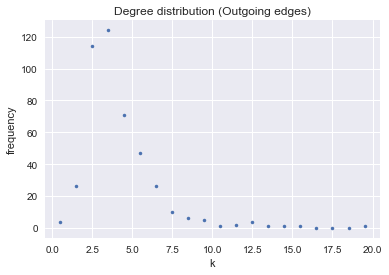

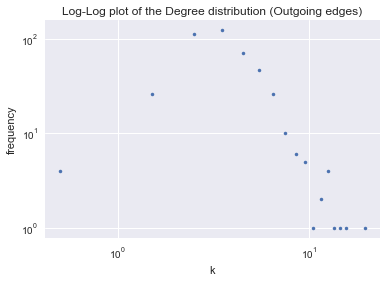

In [120]:
outDegrees = degree_array(congressGraph, direction="out")
scatter_degree_distribution(outDegrees, text="(Outgoing edges)")

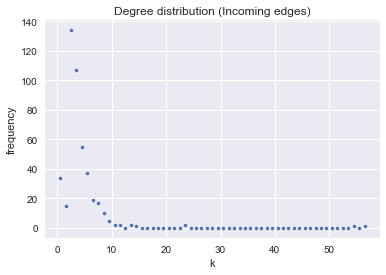

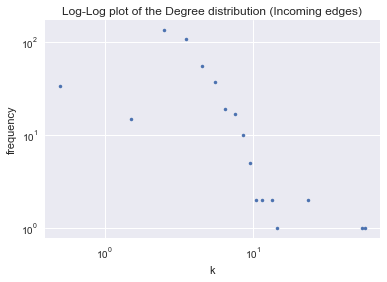

In [121]:
scatter_degree_distribution(inDegrees,  text="(Incoming edges)")

* Describe the distributions (as you would in a well written figure caption). Do they look Poissonian? Power-law? Something in between?

*Answer: The distributions both look poissonian, and the log-log plots reveal this as well, since they are not on a straight line.*

* Plot a scatter plot of the the in- versus out- degree for all politicians. Comment on the relation between the two.

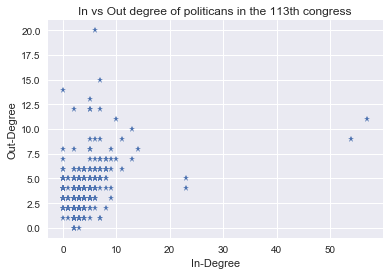

In [122]:
outDegrees = degree_array(congressGraph, direction="out")
plt.plot(inDegrees, outDegrees, "*")
plt.title("In vs Out degree of politicans in the 113th congress")
plt.xlabel("In-Degree")
plt.ylabel("Out-Degree")
plt.show()

*Answer: It seems like there exists an inverse relationship between the two; those pages with few incoming edges have a high amount of outgoing edges, although there are 4 outliers*

* Plot a heatmap of the the in- versus out- degree for all politicians. What is the advantage of using a heatmap?

*Answer: For two variables I would be so bold as to say there isn't a big advantage, but as soon as you are plotting 3 or more variables against each other it a very efficient way of condensing many correlation plots into one*

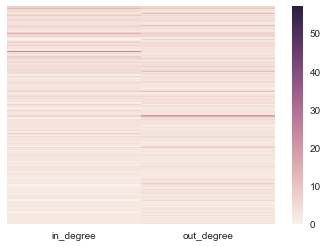

In [123]:
df = pd.DataFrame()
df['in_degree'] = inDegrees
df['out_degree'] = outDegrees
sns.heatmap(df, yticklabels="")
plt.show()

## Exercise 5: Going in depth with the structure of house of representatives network.

*Not all of the measures we'll be considering below are defined for directed graphs, thus begin by creating an undirected version of the graph, that we can use whenever needed. Only use the undirected graph when explicitly stated in the exercise.*

Assortativity: Linking with similar nodes 

Disassortativity: Linking with dissimilar nodes

**Centrality**
* Degree centrality: *Central nodes have the highest degree. Directly correlated with degree.*

* Closeness Centrality: *Based on mean shortest path. Closest mean to neighbours is in middle. Somewhat correlated with degree.*


* Betweenness Centrality: *Measure all shortest paths for the network, count frequency of which the current node appears in shortest paths. Somewhat correlated with degree.*

* Eigenvector Centrality: *Average degree of nodes that point to you. Not necessarily related to degree. How likely is it that a random walk in the network would visit this node. This is used for page ranking. *

**Clique**
* Fully connected subgraph in the network. A community in a social network is a clique.

* Find the 5 most central politicians according to betweenness centrality. What role do you imagine politicians with high wikipedia graph betweenness centrality play?

In [124]:
betweennessDict = nx.betweenness_centrality(undirectedCongressGraph)
sortedByBetweenness = sorted(betweennessDict.keys(), key=lambda k: betweennessDict[k], reverse=True)

In [125]:
for i in range(5):
    print(sortedByBetweenness[i].WikiPageName)

Nancy_Pelosi
John_Boehner
Paul_Ryan
Eric_Cantor
Michele_Bachmann


*Answer: Politicians of high betweenness is likely to be central to the decision made by congress, in the form of a leadership role or being part of many committees*

* Find the 5 most central politicians according to eigenvector centrality. Calculate centrality corresponding to both in- and out-edges

From NetworkX docs:

*For directed graphs this is “left” eigevector centrality which corresponds to the in-edges in the graph. For out-edges eigenvector centrality first reverse the graph with G.reverse().*

In [148]:
leftHandEigenvectorDict = nx.eigenvector_centrality(congressGraph)
sortedByLeftHandEigenvector = sorted(leftHandEigenvectorDict.keys(), key=lambda k: leftHandEigenvectorDict[k], reverse=True)

In [149]:
rightHandEigenvectorDict = nx.eigenvector_centrality(congressGraph.reverse())
sortedByRightHandEigenvector = sorted(rightHandEigenvectorDict.keys(), key=lambda k: rightHandEigenvectorDict[k], reverse=True)

In [150]:
for i in range(5):
    print(sortedByLeftHandEigenvector[i].WikiPageName)

Nancy_Pelosi
John_Boehner
Steny_Hoyer
John_Dingell
Eric_Cantor


In [151]:
for i in range(5):
    print(sortedByRightHandEigenvector[i].WikiPageName)

Michele_Bachmann
Kevin_McCarthy_(California_politician)
Devin_Nunes
Keith_Ellison
Brad_Sherman


* Plot the betweenness centrality of nodes vs their degree centrality. Is there a correlation between the two? Did you expect that? Why?

*Answer: The betweenness is not necessarily linked with degree, but it will be linked with in-degrees, since it is defined by reflecting the probability of being on the path of a random walk in the graph, i.e. which is positively correlated with the in-degree*

In [139]:
betweenness = np.array(list(betweennessDict.values()))

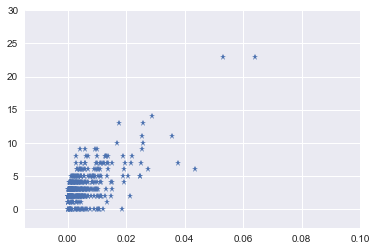

In [163]:
plt.plot(betweenness, inDegrees, "*")
plt.xlim(xmax=0.1)
plt.ylim(ymax=30)
plt.show()

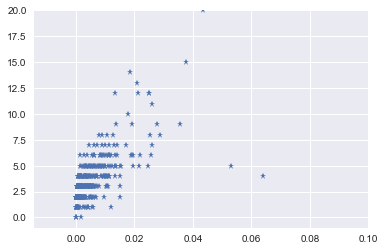

In [164]:
plt.plot(betweenness, outDegrees, "*")
plt.xlim(xmax=0.1)
plt.ylim(ymax=20)
plt.show()

* Repeat the two points above using eigenvector centrality instead. Do you observe any difference? Why?

**Quick maffs**

Let $A = (a_{i,j})$ be the adjacency matrix of a graph. The eigenvector centrality $x_{i}$ of node $i$ is given by: $$x_i = \frac{1}{\lambda} \sum_k a_{k,i} \, x_k$$ where $\lambda \neq 0$ is a constant. In matrix form we have: $$\lambda x = x A$$
Hence the centrality vector $x$ is the left-hand eigenvector of the adjacency matrix $A$ associated with the eigenvalue $\lambda$.

In [155]:
leftHandEigenvalues = list(leftHandEigenvectorDict.values())
rightHandEigenvalues = list(eigenOutDict.values())

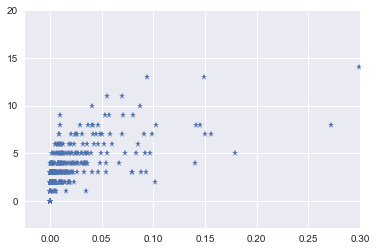

In [165]:
plt.plot(leftHandEigenvalues, inDegrees, "*")
plt.xlim(xmax=0.3)
plt.ylim(ymax=20)
plt.show()

*Answer: For the original graph the left hand eigenvalues are plotted against the in-degrees, which are posively correlated - which makes intuitive sense since the higher the in-degreea node has, the higher the probablity of having nodes high-degree nodes pointing to that node*

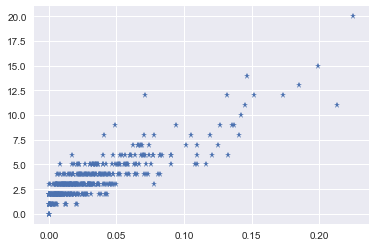

In [159]:
plt.plot(rightHandEigenvalues, outDegrees, "*")

*Answer: Here the graph is reversed, and the out-degrees (which are no the in-degrees) are plotted. Here the correlation seems much more clear*

* Is the undirected version of the graph assortative with respect do degree? (e.g. do high-degree politicians tend to link to other high-degree politicians, and low-degree politicians to other low-degree politicians?). Provide an interpretation of your answer.

In [166]:
assort = nx.degree_assortativity_coefficient(undirectedCongressGraph)

In [168]:
nodes = undirectedCongressGraph.nodes()
a = np.zeros(len(nodes))

In [169]:
for i,n in enumerate(nodes):
    a[i] = nx.degree_assortativity_coefficient(undirectedCongressGraph, [n])
    

In [ ]:
dd